# start

http://localhost:8081/notebooks/git/recsys20/working/prep0318_1.ipynb

In [5]:
PRFX='0318_1'
PRFX_PRP = 'prep0318_1' 
langs = ['544FA32458C903F1125FE6598300A047','6431A618DCF7F4CB7F62A95A39BAB77A']
trntmstmp=1584412344
valtmstmp=1584405047
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-17 00:30:47']

# setup

In [33]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from dask.distributed import Client
import pickle
import lightgbm as lgb

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_prp=f'{HOME}/output/{PRFX_PRP}'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]

tgts     = ['Retweet','Reply','Like','RTwCmnt',]
cols_tgt = ['retwt',  'reply','like','retwt_cmmnt',]


dask.__version__ 2.12.0


# prepare data

In [7]:
ls -hlS $p_prp

total 355M
-rw-rw-r-- 1 ubuntu ubuntu  35M Mar 18 13:41 dftrn_3A85BCEC571C3F5AB1069E4924189177_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  34M Mar 18 13:41 dftrn_69C4A33B9AD29AF883D60BA61CC08702_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  30M Mar 18 13:41 dftrn_CB11E9CF42BD0A1BAD5E27BF3422D99D_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  26M Mar 18 13:41 dftrn_E7BB61D2A87C1E72DF1C7BC292B86A1C_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  23M Mar 18 13:41 dftrn_FF7EABB5A382356D54D9C41BA0125E09_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  20M Mar 18 13:42 dftrn_54208B51D44E7D91DC2F3DD02ADEDEC2_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  19M Mar 18 13:42 dftrn_B6D90127A09AB1229731898AEF9D4D7C_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  17M Mar 18 13:41 dftrn_F4FD40A716F1572C9A28E9CAA58BE3A5_1584412344__prep0318_1.tsv
-rw-rw-r-- 1 ubuntu ubuntu  15M Mar 18 13:42 dftrn_6431A618DCF7F4CB7F62A95A39BAB77A_1584412344__prep0

In [8]:
df = dd.concat([dd.read_csv(f'{p_prp}/dftrn_{lang}_{trntmstmp}__{PRFX_PRP}.tsv',sep='\x01') for lang in langs])

In [9]:
df.head()

,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,...,twttyp_TopLevel,twttyp_Retweet,twttyp_Quote,tmdlta_u2u1,tmdlta_twtu1,tmdlta_twtu2,reply,retwt,retwt_cmmnt,like
0,101\t24106\t11010\t10120\t10874\t18330\t50825\...,NaN,12CDD75B0DC41E6DD9343019D95F2365,NaN,NaN,NaN,Quote,544FA32458C903F1125FE6598300A047,1581371876,E670D3E206D2923AC27699E72E8B569A,...,0,0,1,-182892233,69571670,252463903,0,0,0,0
1,101\t19644\t10138\t63216\t11274\t100\t102,NaN,ADCA98A9FF35EBE74C3C12D53CCEC0C4,NaN,NaN,NaN,TopLevel,544FA32458C903F1125FE6598300A047,1581428912,6D5E2601CDE9E9EB34BDA5CCD92B3743,...,1,0,0,132808538,186678592,53870054,0,0,0,0
2,101\t56898\t137\t103721\t79182\t11273\t29925\t...,NaN,3DD2B01983D2454C5E150191F667CA63,Video,NaN,NaN,Retweet,544FA32458C903F1125FE6598300A047,1580952031,C4B7B381CF12EBDFBC84E613AFB1CB47,...,0,1,0,194327490,231359417,37031927,0,0,0,0
3,101\t10421\t43786\t17394\t17394\t100\t102,NaN,8C8B808B8CB18DE76A58D58E4F80E616,NaN,NaN,NaN,Quote,544FA32458C903F1125FE6598300A047,1581453553,E264BA5D049295B09F1568C92436A33B,...,0,0,1,-3926344,272041002,275967346,0,0,0,0
4,101\t156\t21948\t11998\t57667\t10263\t102,NaN,1282645FAA1BF0CBAF8191CB4CBFA000,NaN,NaN,NaN,Quote,544FA32458C903F1125FE6598300A047,1581339023,C14BA3D40CDC8AF0F6DDF5F75B5BC30B,...,0,0,1,-38798407,10741506,49539913,0,1,0,0


In [10]:
%%time
# https://stackoverflow.com/questions/40376425/dask-dataframe-equivalent-of-pandas-dataframe-sort-values
lendf = df.shape[0].compute()
valsz = int(lendf*0.15)
trnsz = lendf-valsz
lendf, trnsz, valsz

CPU times: user 562 ms, sys: 127 ms, total: 688 ms
Wall time: 481 ms


(58567, 49782, 8785)

In [12]:
dftr=df.nsmallest(trnsz,'tm')
dfvl=df.nlargest(valsz,'tm')

In [14]:
assert dfvl.tm.min().compute() > dftr.tm.max().compute()

In [16]:
dftr.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'reply', 'retwt',
       'retwt_cmmnt', 'like'],
      dtype='object')

In [18]:
cols_feat=[
       'tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2',
]

In [19]:
X, ys = (df[cols].to_dask_array(lengths=True) for cols in (cols_feat,cols_tgt))

Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15, random_state=SEED)

# train

In [20]:
client = Client()

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [21]:
params = {'objective': 'binary:logistic'}

In [22]:
tgt2bst={}
tgt2col2fscr={}
for i,tgt in enumerate(tgts):
    bst = dask_xgboost.train(client, params,
                             Xtrn, ystrn[:,i],
                             num_boost_round=20)
    tgt2bst[tgt]=bst
    print(dtnow(), tgt)
    
    fi2col=dict(zip(bst.feature_names, cols_feat))
    col2fi=dict(zip(cols_feat, bst.feature_names))
    fi2fscr=bst.get_fscore()
    col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
    tgt2col2fscr[tgt]=col2fscr

pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-18 13:49:11 Retweet
2020-03-18 13:49:16 Reply
2020-03-18 13:49:22 Like
2020-03-18 13:49:26 RTwCmnt


In [23]:
tgt2bst=pickle.load(open(f"{p_out}/tgt2bst.p", "rb"))

In [24]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
#     show_feat_importance(tgt2bst[tgt])
    col2fscr=tgt2col2fscr[tgt]
    display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

Retweet


,0,1
6,u2_following_cnt,125
1,u1_fllwer_cnt,122
2,u1_fllwing_cnt,120
5,u2_follower_cnt,112
10,len_toks,101
8,u2_create_tm,89
0,tm,83
4,u1_create_tm,78
20,tmdlta_u2u1,70
14,num_hshtgs,38


Reply


,0,1
10,len_toks,92
2,u1_fllwing_cnt,92
5,u2_follower_cnt,92
1,u1_fllwer_cnt,90
6,u2_following_cnt,89
0,tm,79
8,u2_create_tm,72
4,u1_create_tm,65
20,tmdlta_u2u1,64
22,tmdlta_twtu2,52


Like


,0,1
1,u1_fllwer_cnt,160
2,u1_fllwing_cnt,133
10,len_toks,131
5,u2_follower_cnt,106
0,tm,105
6,u2_following_cnt,98
4,u1_create_tm,85
8,u2_create_tm,79
20,tmdlta_u2u1,52
22,tmdlta_twtu2,33


RTwCmnt


,0,1
5,u2_follower_cnt,109
6,u2_following_cnt,88
10,len_toks,84
8,u2_create_tm,75
2,u1_fllwing_cnt,70
1,u1_fllwer_cnt,64
0,tm,63
20,tmdlta_u2u1,52
4,u1_create_tm,32
19,twttyp_Quote,19


# validate

In [25]:
tgt2yval={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt)
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2yval[tgt]=yval
    tgt2prdval[tgt]=prdval

2020-03-18 13:49:27 Retweet
2020-03-18 13:49:27 Reply
2020-03-18 13:49:28 Like
2020-03-18 13:49:28 RTwCmnt


In [26]:
def show_roc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

Retweet
auc: 0.17391770281306418
rce: 5.950227309685385


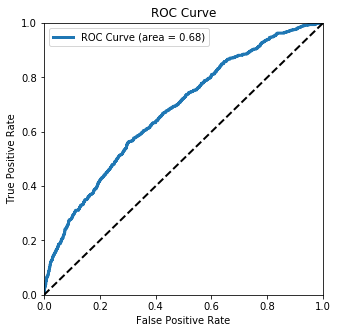

Reply
auc: 0.07107083042817167
rce: 6.333427345738585


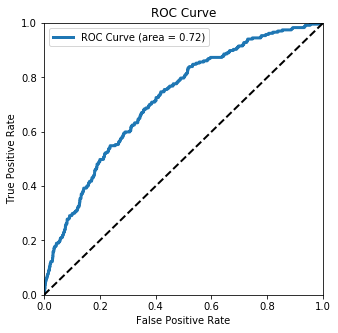

Like
auc: 0.7647744373472197
rce: 17.625596866691716


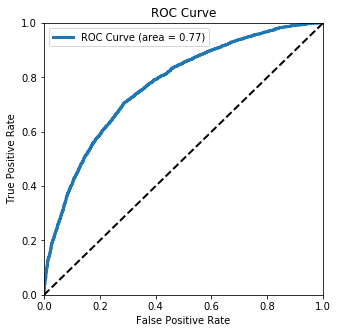

RTwCmnt
auc: 0.01827672141392734
rce: 2.1263220044618114


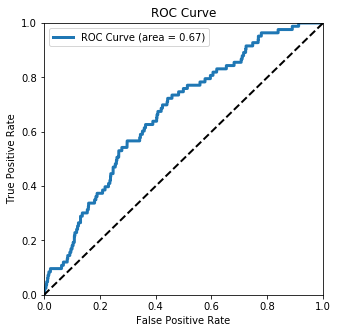

In [27]:
tgt2auc={}
tgt2rce={}
for i,tgt in enumerate(tgts):
    print(tgt)
    yval = tgt2yval[tgt]
    prdval = tgt2prdval[tgt]
    scr_auc=compute_prauc(prdval, yval)
    scr_rce=compute_rce(prdval, yval)
    tgt2auc[tgt]=scr_auc
    tgt2rce[tgt]=scr_rce
    print('auc:',scr_auc)
    print('rce:', scr_rce)
    show_roc(prdval, yval)

In [28]:
lst=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lst+=[(f'PRAUC {tgt}',tgt2auc[tgt]),
          (f'RCE {tgt}',tgt2rce[tgt])]

In [29]:
pd.DataFrame(lst).T

,0,1,2,3,4,5,6,7
0,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
1,0.173918,5.95023,0.0710708,6.33343,0.764774,17.6256,0.0182767,2.12632


# infer

In [30]:
ls {p_in} | grep {valtmstmp}

val_12D8CEB94F89D11D7EB95EAE9689B009_1584405047.tsv
val_1584405047_1e3.tsv
val_1584405047.tsv*
val_1BC639981AE88E09129594B11F894A21_1584405047.tsv
val_2216D01F7B48554E4211021A46816FCF_1584405047.tsv
val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv
val_2E18F6F53E3CF073911AF0A93BBE5373_1584405047.tsv
val_3121F7240D488F74EEED9312E174B217_1584405047.tsv
val_3A85BCEC571C3F5AB1069E4924189177_1584405047.tsv
val_4249CE88433AEA3F8DCEECF008B3CB95_1584405047.tsv
val_4690215948DBF6872B8ED1C2BC87B17E_1584405047.tsv
val_515E873C86EE1577E75FA2387B7FA59E_1584405047.tsv
val_54208B51D44E7D91DC2F3DD02ADEDEC2_1584405047.tsv
val_544FA32458C903F1125FE6598300A047_1584405047.tsv
val_57ADD4576E2AD6648E9B2DE32F3462A5_1584405047.tsv
val_60A3DB168094D41241E45E0DE3539BC0_1584405047.tsv
val_6431A618DCF7F4CB7F62A95A39BAB77A_1584405047.tsv
val_69C4A33B9AD29AF883D60BA61CC08702_1584405047.tsv
val_97F81BD92A1ACA3F1F43C154E689350F_1584405047.tsv
val_A6B70CDF8C7B934D4A218CA9B6B7FDB4_1584405047.tsv
val_AA0254541959271ED

In [31]:
ls {p_prp} | grep {valtmstmp}

dfval_12D8CEB94F89D11D7EB95EAE9689B009_1584405047__prep0318_1.tsv
dfval_1BC639981AE88E09129594B11F894A21_1584405047__prep0318_1.tsv
dfval_2216D01F7B48554E4211021A46816FCF_1584405047__prep0318_1.tsv
dfval_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047__prep0318_1.tsv
dfval_2E18F6F53E3CF073911AF0A93BBE5373_1584405047__prep0318_1.tsv
dfval_3121F7240D488F74EEED9312E174B217_1584405047__prep0318_1.tsv
dfval_3A85BCEC571C3F5AB1069E4924189177_1584405047__prep0318_1.tsv
dfval_4690215948DBF6872B8ED1C2BC87B17E_1584405047__prep0318_1.tsv
dfval_515E873C86EE1577E75FA2387B7FA59E_1584405047__prep0318_1.tsv
dfval_54208B51D44E7D91DC2F3DD02ADEDEC2_1584405047__prep0318_1.tsv
dfval_544FA32458C903F1125FE6598300A047_1584405047__prep0318_1.tsv
dfval_57ADD4576E2AD6648E9B2DE32F3462A5_1584405047__prep0318_1.tsv
dfval_60A3DB168094D41241E45E0DE3539BC0_1584405047__prep0318_1.tsv
dfval_6431A618DCF7F4CB7F62A95A39BAB77A_1584405047__prep0318_1.tsv
dfval_69C4A33B9AD29AF883D60BA61CC08702_1584405047__prep0318_1.tsv
dfval_97F8

In [42]:
dftst=dd.read_csv(
    f'{p_prp}/dfval_{valtmstmp}__{PRFX_PRP}.tsv',
    sep='\x01',
    encoding='utf8')

In [43]:
Xtst = dftst[cols_feat].to_dask_array(lengths=True)

In [44]:
%%time
tgt2prdtst={}
for i,tgt in enumerate(tgts):
    prdtst = dask_xgboost.predict(client, tgt2bst[tgt], Xtst)
    prdtst = prdtst
    tgt2prdtst[tgt]=prdtst 

CPU times: user 6.44 ms, sys: 6.97 ms, total: 13.4 ms
Wall time: 15.5 ms


In [46]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [ ]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False,single_file=True)

In [35]:
# %%time
# for tgt in tgts:
#     print(dtnow(), tgt)
#     dfsub = pd.concat(pd.read_csv(o, header=None) for o in sorted(glob.glob(f'{p_out}/{tgt}__{PRFX}_*.csv')))
#     dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv', 
#                           index=False, 
#                           header=False)

In [36]:
!head -n 2 {p_prp}/val_{valtmstmp}.tsv

101	47185	10157	100986	10343	55422	119	14120	131	120	120	188	119	11170	120	162	10162	10575	10237	11281	10123	11305	11537	10350	10115	1027647B4E9DAF4C1D8973397DC2A04F3E3PhotoTopLevelD3164C7FBCF2565DDF915B1B3AEFB1DC15817031268A9AB92B775C62C4AB60DF6773A01571139411216false14482921860000006C3074607050F1339DDCB890BB27448600false1520948869true
101	6006	5086	1939	7418	3601	6406	1913	3800	21252	18767	2369	5322	8255	3671	14813	20058	4335	1912	22480	111814	18872	91872	108247	12236	5078	1923	11312	16838	15802	18825	60847	1881	1881	1881	4476	3740	65236	10898	103305	1881	1881	1881	1881	1881	1881	3102	77509	4726	1939	2195	2149	11592	15802	50508	52310	1881	1881	1881	1881	1881	1881	1881	14120	131	120	120	188	119	11170	120	153	10477	13034	12674	58123	10929	10410	102CCBFBA5AFE7EFC03102EA8D0F86C4208PhotoTopLevel22C448FF81263D4BAF2A176145EE9EAD1581736431187AC59639DA9A6F32F7CD118EDD58F74764391478false125444772200000776B07587ECA9717BFC301F2D6E102659false1478011810false


In [37]:
for tgt in tgts:
    !head -n 2 {p_out}/{tgt}__{valtmstmp}__{PRFX}.csv

7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.08658835
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.10320493
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.07894471
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.020714642
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.44839406
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.37307036
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.014331817
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.0054969722
